# **Predict Bike Sharing Demand with AutoGluon Template**

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
2. Scroll down to API and click Create New API Token.
3. Open up `kaggle.json` and use the username and key.

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [ ]:
%%capture

!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [ ]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "xxxx"
kaggle_key = "xxxx"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the [bike sharing demand competition](https://www.kaggle.com/c/bike-sharing-demand) and agree to the terms.

In [ ]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 18.9MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
from autogluon.tabular import TabularPredictor
import time

In [ ]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv', parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [ ]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv', parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv', parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset.
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [ ]:
predictor = TabularPredictor(
    label="count",
    eval_metric="root_mean_squared_error",
    learner_kwargs={"ignored_columns": ["casual", "registered"]}
).fit(
    train_data=train,
    time_limit=600,
    presets="best_quality"
)


No path specified. Models will be saved in: "AutogluonModels/ag-20230614_120952/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230614_120952/"
AutoGluon Version:  0.7.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Apr 29 09:15:28 UTC 2023
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using F

### Review AutoGluon's training run with ranking of models that did the best.

In [ ]:
predictor.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-53.155928,23.094528,496.560885,0.000663,0.243464,3,True,13
1,RandomForestMSE_BAG_L2,-53.474405,17.798489,389.446133,0.612285,40.559677,2,True,11
2,LightGBM_BAG_L2,-55.188546,17.675386,380.196531,0.489182,31.310076,2,True,10
3,CatBoost_BAG_L2,-56.700732,17.360301,392.806175,0.174097,43.919719,2,True,12
4,LightGBMXT_BAG_L2,-60.188814,21.992399,424.447668,4.806195,75.561212,2,True,9
5,KNeighborsDist_BAG_L1,-84.125061,0.085134,0.077044,0.085134,0.077044,1,True,2
6,WeightedEnsemble_L2,-84.125061,0.086155,1.155456,0.001022,1.078413,2,True,8
7,KNeighborsUnif_BAG_L1,-101.546199,0.078435,0.061918,0.078435,0.061918,1,True,1
8,RandomForestMSE_BAG_L1,-116.548359,0.536063,22.819614,0.536063,22.819614,1,True,5
9,ExtraTreesMSE_BAG_L1,-124.600676,0.539298,7.851158,0.539298,7.851158,1,True,7


### Create predictions from test dataset

In [ ]:
predictions = predictor.predict(test)
predictions.head()

0    22.787867
1    42.352966
2    46.123871
3    49.392597
4    52.044563
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [ ]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.597511
std        90.149376
min         2.994517
25%        19.700634
50%        64.090927
75%       167.907104
max       369.014435
Name: count, dtype: float64

In [ ]:
# How many negative values do we have?
predictions[predictions < 0]

Series([], Name: count, dtype: float32)

In [ ]:
# Set them to zero
predictions[predictions < 0] = 0

### Set predictions to submission dataframe, save, and submit

In [ ]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:03<00:00, 51.5kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [ ]:
time.sleep(5)
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 3

fileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission.csv               2023-06-14 12:21:18  first raw submission                 complete  1.80798      1.80798       


#### Initial score of `1.80798`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>]], dtype=object)

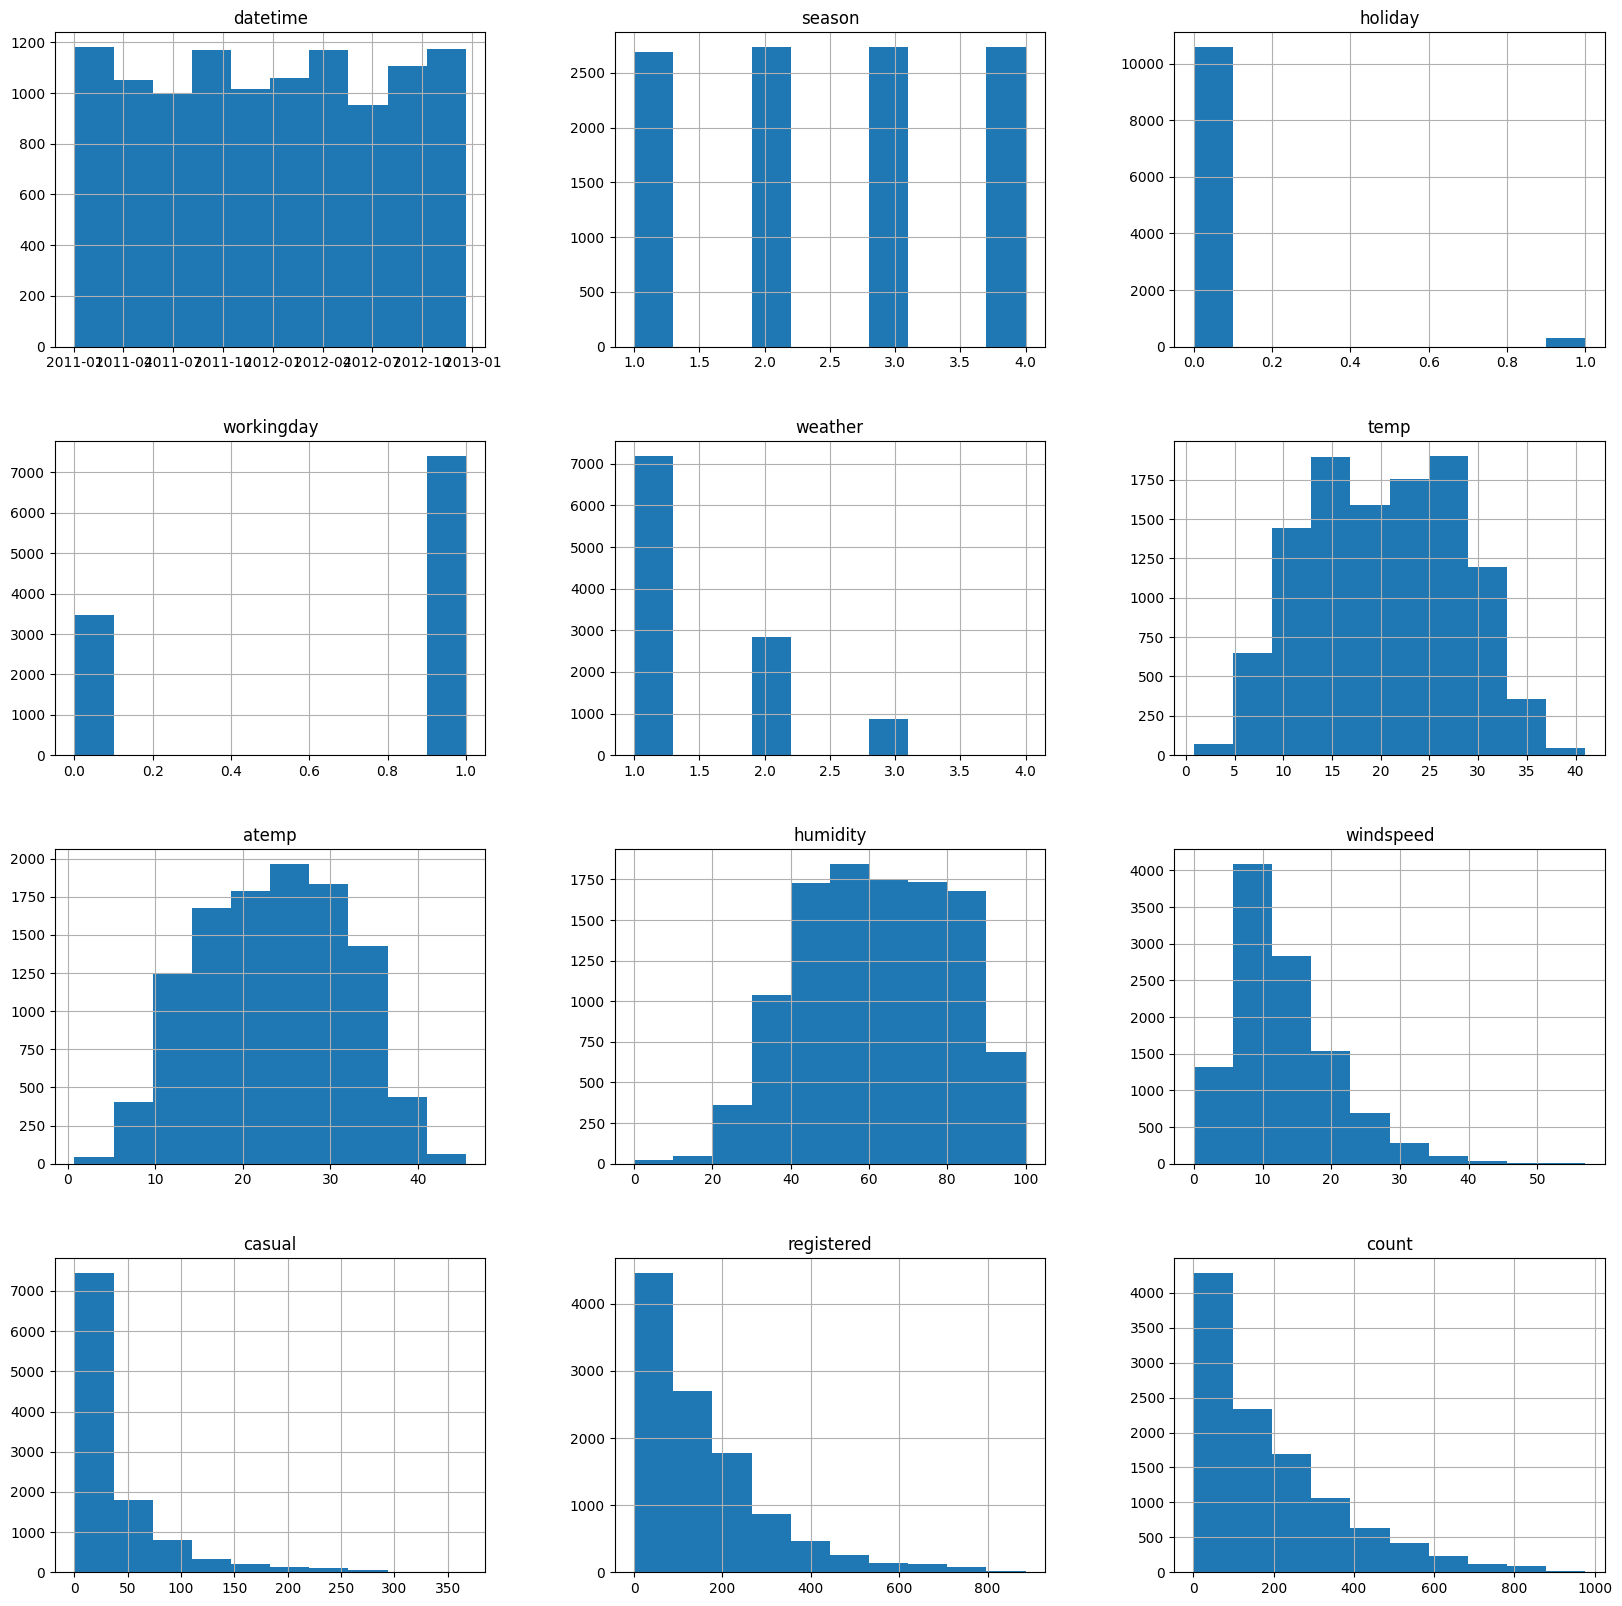

In [ ]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploratory data analysis
train.hist(figsize=(20,20))


In [ ]:
# Add a new feature to the dataset (dayofweek, represented as a category)
train['dayofweek'] = train['datetime'].dt.dayofweek
train = train.astype({"dayofweek": "category"})

test['dayofweek'] = test['datetime'].dt.dayofweek
test = test.astype({"dayofweek": "category"})


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [ ]:
# Turn 'season' and 'weather' into category type
train = train.astype({"season": "category", "weather": "category"})
test = test.astype({"season": "category", "weather": "category"})


In [ ]:
# View the new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,5


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>],
       [<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>],
       [<Axes: title={'center': 'count'}>, <Axes: >, <Axes: >]],
      dtype=object)

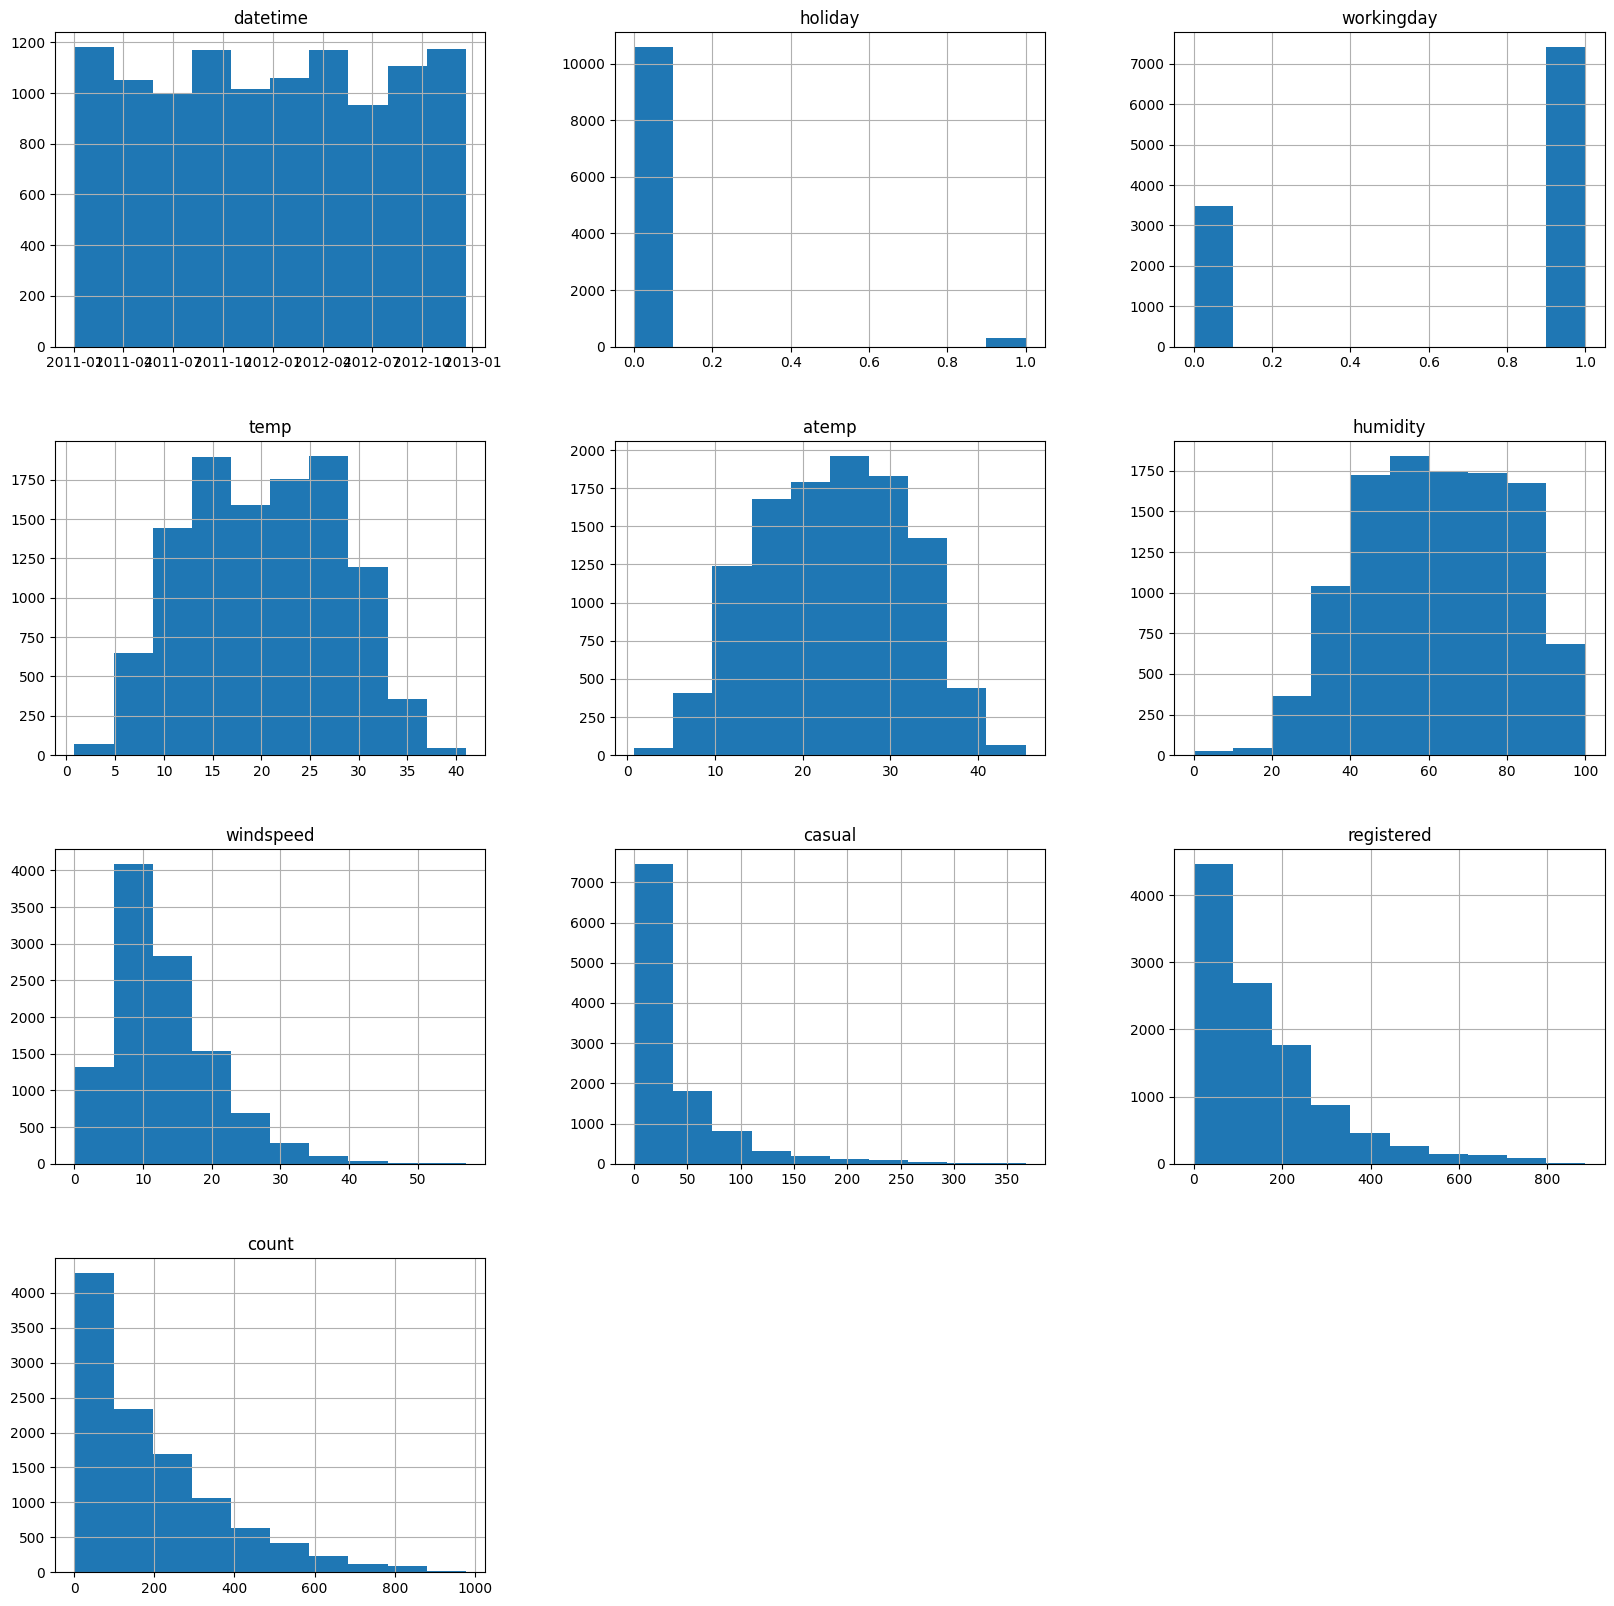

In [ ]:
# View histogram of all features again now with the day of week feature
train.hist(figsize=(20, 20))

## Step 5: Rerun the model with the same settings as before, just with more features

In [ ]:
predictor_new_features = TabularPredictor(
    label="count",
    eval_metric="root_mean_squared_error",
    learner_kwargs={"ignored_columns": ["casual", "registered"]}
).fit(
    train_data=train,
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230614_122415/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230614_122415/"
AutoGluon Version:  0.7.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Apr 29 09:15:28 UTC 2023
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using F

In [ ]:
predictor_new_features.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-53.024033,22.869867,573.297477,0.000641,0.204859,3,True,13
1,RandomForestMSE_BAG_L2,-53.311608,16.962404,451.186240,0.620526,48.855812,2,True,12
2,LightGBM_BAG_L2,-55.065665,16.912822,446.885679,0.570945,44.555252,2,True,11
3,LightGBMXT_BAG_L2,-61.411635,21.677755,479.681555,5.335877,77.351127,2,True,10
4,KNeighborsDist_BAG_L1,-84.125061,0.071213,0.054664,0.071213,0.054664,1,True,2
5,WeightedEnsemble_L2,-84.125061,0.074166,0.855059,0.002952,0.800394,2,True,9
6,KNeighborsUnif_BAG_L1,-101.546199,0.083087,0.059564,0.083087,0.059564,1,True,1
7,RandomForestMSE_BAG_L1,-116.684536,0.757569,14.913776,0.757569,14.913776,1,True,5
8,ExtraTreesMSE_BAG_L1,-124.440876,0.587915,6.091911,0.587915,6.091911,1,True,7
9,LightGBM_BAG_L1,-130.339419,2.898045,41.739228,2.898045,41.739228,1,True,4


In [ ]:
# Remember to set all negative values to zero
prediction_new_features = predictor_new_features.predict(test)
prediction_new_features[prediction_new_features < 0] = 0




In [ ]:
# Same submitting predictions

submission_new_features = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_features["count"] = prediction_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100% 188k/188k [00:04<00:00, 47.0kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
time.sleep(5)
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 4

fileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_features.csv  2023-06-14 12:35:54  new features                         complete  1.78974      1.78974       
submission.csv               2023-06-14 12:21:18  first raw submission                 complete  1.80798      1.80798       


#### New Score of `1.78974`

## Step 6: Hyperparameter optimization
* There are many options for hyperparameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [ ]:
import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'layers': ag.space.Categorical([100], [1000], [200, 100], [300, 200, 100]),  # each choice for categorical hyperparameter 'layers' corresponds to list of sizes for each NN layer to use
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limit = 2*60  # train various models for ~2 min
num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using Bayesian optimization routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}


predictor_new_hpo = TabularPredictor(
    label="count",
    eval_metric="root_mean_squared_error",
    learner_kwargs={"ignored_columns": ["casual", "registered"]}
).fit(
    train_data=train,
    time_limit=600,
    presets="best_quality",
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
)


No path specified. Models will be saved in: "AutogluonModels/ag-20230614_123643/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230614_123643/"
AutoGluon Version:  0.7.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Apr 29 09:15:28 UTC 2023
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using F

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	-135.1137	 = Validation score   (-root_mean_squared_error)
	31.59s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T2 ...
	-135.019	 = Validation score   (-root_mean_squared_error)
	29.58s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T3 ...
	-133.8163	 = Validation score   (-root_mean_squared_error)
	39.73s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T4 ...
	-155.9745	 = Validation score

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
ray::_ray_fit() (pid=24676, ip=172.28.0.12)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 374, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold,
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/abstract/abstract_model.py", line 703, in fit
    out = self._fit(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/models/tabular_nn/mxnet/tabular_nn_mxnet.py", line 156, in _fit
    train_dataset, val_dataset = self.generate_datasets(X=X, y=y, params=params, X_val=X_val, y_val=y_val)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/models/tabular_nn/mxnet/tabular_nn_mxnet.py", line 446, in generate_datasets
    train_dataset = self.process_train_data(
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/models/tabular_nn/mxnet/tabula

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L2/T1 ...
	-133.6422	 = Validation score   (-root_mean_squared_error)
	28.35s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T2 ...
	-133.6439	 = Validation score   (-root_mean_squared_error)
	30.08s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T3 ...
	-134.1354	 = Validation score   (-root_mean_squared_error)
	34.51s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T4 ...
	-149.039	 = Validation score

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
ray::_ray_fit() (pid=27184, ip=172.28.0.12)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 374, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold,
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/abstract/abstract_model.py", line 703, in fit
    out = self._fit(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/models/tabular_nn/mxnet/tabular_nn_mxnet.py", line 156, in _fit
    train_dataset, val_dataset = self.generate_datasets(X=X, y=y, params=params, X_val=X_val, y_val=y_val)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/models/tabular_nn/mxnet/tabular_nn_mxnet.py", line 446, in generate_datasets
    train_dataset = self.process_train_data(
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/models/tabular_nn/mxnet/tabula

In [ ]:
predictor_new_hpo.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-133.448104,0.002222,252.112528,0.001037,0.525877,3,True,12
1,LightGBM_BAG_L2/T1,-133.642158,0.000892,186.996161,0.000170,28.351196,2,True,7
2,LightGBM_BAG_L2/T2,-133.643882,0.000862,188.729145,0.000140,30.084179,2,True,8
3,WeightedEnsemble_L2,-133.795214,0.001288,69.862716,0.001003,0.555212,2,True,6
4,LightGBM_BAG_L1/T3,-133.816341,0.000155,39.727154,0.000155,39.727154,1,True,3
5,LightGBM_BAG_L2/T5,-133.980517,0.000889,196.955037,0.000166,38.310071,2,True,11
6,LightGBM_BAG_L2/T3,-134.135447,0.000875,193.151276,0.000153,34.506310,2,True,9
7,LightGBM_BAG_L1/T2,-135.019022,0.000130,29.580350,0.000130,29.580350,1,True,2
8,LightGBM_BAG_L1/T1,-135.113693,0.000144,31.586029,0.000144,31.586029,1,True,1
9,LightGBM_BAG_L1/T5,-135.765733,0.000150,28.162464,0.000150,28.162464,1,True,5


In [ ]:
# Remember to set all negative values to zero
prediction_new_hpo = predictor_new_hpo.predict(test)
prediction_new_hpo[prediction_new_hpo < 0] = 0


In [ ]:
# Same submitting predictions
submission_new_hpo = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_hpo["count"] = prediction_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100% 188k/188k [00:02<00:00, 78.0kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
time.sleep(5)
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 5

fileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-06-14 12:43:37  new features with hyperparameters    complete  1.32159      1.32159       
submission_new_features.csv  2023-06-14 12:35:54  new features                         complete  1.78974      1.78974       
submission.csv               2023-06-14 12:21:18  first raw submission                 complete  1.80798      1.80798       


#### New Score of `1.32159`

## New sets of hyperparameters: Smaller networks and fewer leaves ##

In an attempt to improve fitting, the size of gradient boosting and neural network models was reduced to a size reckoned to be more compatible with the dataset.

Since the neural networks are much larger than the problem and none of them reached a high score either on Kaggle or in relation to other methods trained by Autogluon, the networks might have an overfitting problem, which could be reduced by training smaller networks with higher dropout rates.

The same approach was applied to gradient boosting methods. The number of leaves was reduced in an attempt to reduce the possibility of overfitting.




In [ ]:
time_limit = 2*60  # train various models for ~2 min
num_trials = 10  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using Bayesian optimization routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=16, upper=36, default=26),  # number of leaves in trees (integer hyperparameter)
}

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'layers': ag.space.Categorical([10], [15], [20, 10], [30, 20, 10]),  # each choice for categorical hyperparameter 'layers' corresponds to list of sizes for each NN layer to use
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.2),  # dropout probability (real-valued hyperparameter)
}


predictor_new_hpo2 = TabularPredictor(
    label="count",
    eval_metric="root_mean_squared_error",
    learner_kwargs={"ignored_columns": ["casual", "registered"]}
).fit(train_data=train,
      time_limit=600,
      presets="best_quality",
      hyperparameters=hyperparameters,
      hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
)


No path specified. Models will be saved in: "AutogluonModels/ag-20230614_131828/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230614_131828/"
AutoGluon Version:  0.7.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Apr 29 09:15:28 UTC 2023
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using F

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	-135.1137	 = Validation score   (-root_mean_squared_error)
	33.0s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T2 ...
	-135.019	 = Validation score   (-root_mean_squared_error)
	28.1s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T3 ...
	-133.8163	 = Validation score   (-root_mean_squared_error)
	31.78s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T4 ...
	-155.9745	 = Validation score  

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
ray::_ray_fit() (pid=38049, ip=172.28.0.12)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 374, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold,
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/abstract/abstract_model.py", line 703, in fit
    out = self._fit(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/models/tabular_nn/mxnet/tabular_nn_mxnet.py", line 156, in _fit
    train_dataset, val_dataset = self.generate_datasets(X=X, y=y, params=params, X_val=X_val, y_val=y_val)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/models/tabular_nn/mxnet/tabular_nn_mxnet.py", line 446, in generate_datasets
    train_dataset = self.process_train_data(
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/models/tabular_nn/mxnet/tabula

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L2/T1 ...
	-133.6422	 = Validation score   (-root_mean_squared_error)
	32.3s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T2 ...
	-133.6439	 = Validation score   (-root_mean_squared_error)
	28.66s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T3 ...
	-134.1354	 = Validation score   (-root_mean_squared_error)
	29.35s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T4 ...
	-149.039	 = Validation score 

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
ray::_ray_fit() (pid=41166, ip=172.28.0.12)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 374, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold,
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/abstract/abstract_model.py", line 703, in fit
    out = self._fit(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/models/tabular_nn/mxnet/tabular_nn_mxnet.py", line 156, in _fit
    train_dataset, val_dataset = self.generate_datasets(X=X, y=y, params=params, X_val=X_val, y_val=y_val)
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/models/tabular_nn/mxnet/tabular_nn_mxnet.py", line 446, in generate_datasets
    train_dataset = self.process_train_data(
  File "/usr/local/lib/python3.10/dist-packages/autogluon/tabular/models/tabular_nn/mxnet/tabula

In [ ]:
predictor_new_hpo2.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-133.448104,0.002282,245.166129,0.001094,0.519037,3,True,12
1,LightGBM_BAG_L2/T1,-133.642158,0.000874,186.639130,0.000143,32.298705,2,True,7
2,LightGBM_BAG_L2/T2,-133.643882,0.000899,182.999728,0.000168,28.659303,2,True,8
3,WeightedEnsemble_L2,-133.795214,0.003571,61.178118,0.003254,1.296506,2,True,6
4,LightGBM_BAG_L1/T3,-133.816341,0.000169,31.777451,0.000169,31.777451,1,True,3
5,LightGBM_BAG_L2/T5,-133.980517,0.000907,185.898972,0.000176,31.558547,2,True,11
6,LightGBM_BAG_L2/T3,-134.135447,0.000876,183.689084,0.000145,29.348659,2,True,9
7,LightGBM_BAG_L1/T2,-135.019022,0.000148,28.104161,0.000148,28.104161,1,True,2
8,LightGBM_BAG_L1/T1,-135.113693,0.000131,32.997145,0.000131,32.997145,1,True,1
9,LightGBM_BAG_L1/T5,-135.765733,0.000142,29.184814,0.000142,29.184814,1,True,5


In [ ]:
prediction_new_hpo2 = predictor_new_hpo2.predict(test)
prediction_new_hpo2[prediction_new_hpo2 < 0] = 0

submission_new_hpo2 = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_hpo2["count"] = prediction_new_hpo2
submission_new_hpo2.to_csv("submission_new_hpo2.csv", index=False)

!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo2.csv -m "new features with hyperparameters 2"
time.sleep(5)
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

100% 188k/188k [00:02<00:00, 75.2kB/s]
Successfully submitted to Bike Sharing DemandfileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_hpo2.csv      2023-06-14 13:26:29  new features with hyperparameters 2  complete  1.32159      1.32159       
submission_new_hpo.csv       2023-06-14 12:43:37  new features with hyperparameters    complete  1.32159      1.32159       
submission_new_features.csv  2023-06-14 12:35:54  new features                         complete  1.78974      1.78974       
submission.csv               2023-06-14 12:21:18  first raw submission                 complete  1.80798      1.80798       


## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

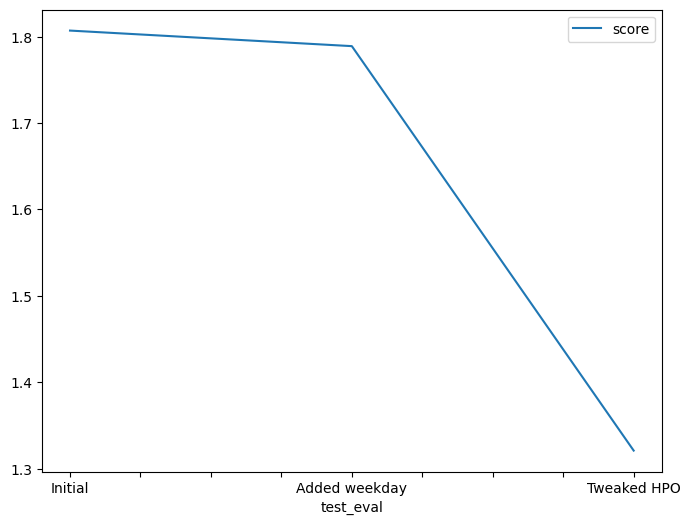

In [ ]:
# Take the 3 Kaggle scores and create a line plot to show improvement
website_output = !kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 5
kaggle_scores = list(reversed([float(i[95:102]) for i in website_output[2:6]]))

fig = pd.DataFrame(
    {
        "test_eval": ["Initial", "Added weekday", "Tweaked HPO"],
        "score": kaggle_scores
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()

fig.savefig('model_test_score.png')

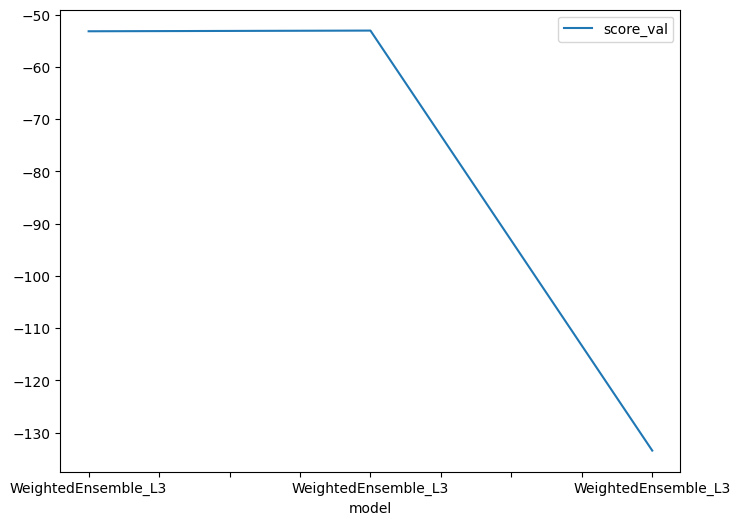

In [ ]:
# Take the top model score from each training run and create a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. Google Sheets, Excel)

fig = (
    pd.concat(
        [
            p.leaderboard(silent=True).iloc[[0]][["model", "score_val"]]
            for p in (predictor, predictor_new_features, predictor_new_hpo)
        ]
    )
    .plot(x="model", y="score_val", figsize=(8, 6))
    .get_figure()
)

fig.savefig("model_train_score.png")

### Hyperparameter table

In [ ]:
# The hyperparameters we tuned and the resulting Kaggle score
pd.DataFrame({
    "Model": ["Initial", "Add weekday", "HPO Tuning", "HPO Tuning 2"],
    "Method": ["Weighted Ensemble L3", "Weighted Ensemble L3", "Weighted Ensemble L3", "Weighted Ensemble L3"],
    "Kaggle Score": kaggle_scores + [1.321],
})

,Model,Method,Kaggle Score
0,Initial,Weighted Ensemble L3,1.807
1,Add weekday,Weighted Ensemble L3,1.789
2,HPO Tuning,Weighted Ensemble L3,1.321
3,HPO Tuning 2,Weighted Ensemble L3,1.321
